In [2]:
import logging
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
logging.basicConfig(level=logging.INFO, force=True)
import os
csv_file_path = "/data/air/pc/Mobile-Search-Engine/datasets/clotho/clotho_captions_evaluation.csv"
data_dir="/data/air/pc/Mobile-Search-Engine/datasets/clotho/evaluation"
# f_s=os.listdir(data_dir)
# print(len(f_s))
pf=pd.read_csv(csv_file_path,sep=',') # 假设数据集以CSV文件形式提供
text_list = pf[['caption_1', 'caption_2', 'caption_3', 'caption_4', 'caption_5']].values.flatten().tolist()
audio_list=pf[['file_name']].values.flatten().tolist()
audio_path=["/data/air/pc/Mobile-Search-Engine/datasets/clotho/evaluation/"+file for file in audio_list]
import random
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")



In [4]:
def find_first_nonzero_row(array, column_index):
    for i, row in enumerate(array):
        if row[column_index] != 0:
            return i
    return 12

# Define a function to calculate the sum of an array
def array_sum(arr):
    return sum(arr)

filenames = ['t24_a{0}.txt'.format(i) for i in range(1,13)]
files = [os.path.join('/data/air/pc/Mobile-Search-Engine/results/clotho/R10',file) for file in filenames]
counts = np.array([])
counts = [np.loadtxt(file) for file in files]
audio_layers={}
for i in range(len(audio_list)):
    audio_layers[i]=[]
for i in range(len(audio_list)):
    audio_id=i
    for j in range(5*audio_id,5*audio_id+5):        
        audio_layers[i].append(find_first_nonzero_row(np.array(counts),j))


sums_and_indices = [(sum(audio_layers[i]), i) for i in range(len(audio_layers))]

# Sort the sums and indices based on the sums
sorted_sums_and_indices = sorted(sums_and_indices, key=lambda x: x[0])

# Extract sorted sums and corresponding indices
sorted_sums = [item[0] for item in sorted_sums_and_indices]
sorted_indices = [item[1] for item in sorted_sums_and_indices]

audio_result=sorted_indices[0:10]+sorted_indices[500:510]+sorted_indices[1000:1010]
embeddings={}
embeddings_average={}
with torch.no_grad():
    for i in range(1,13):
        embeddings[f'layer_{i}']=[]
        embeddings_average[f'layer_{i}']=[]
    for a_block in range(1,13):
        checkpoint = torch.load(f'/data/air/pc/Mobile-Search-Engine/embeddings_{a_block}.pth')
        # 获取模型参数和张量
        emb= checkpoint['audio_embeddings']
        for k in audio_result:
            embeddings[f'layer_{a_block}'].append(emb[int(k)])
        for i in range(3):
                sum_vector = torch.stack(embeddings[f'layer_{a_block}'][i:i+10]).sum(dim=0)

                # 计算平均向量
                mean_vector = sum_vector / 10

                embeddings_average[f'layer_{a_block}'].append(mean_vector)





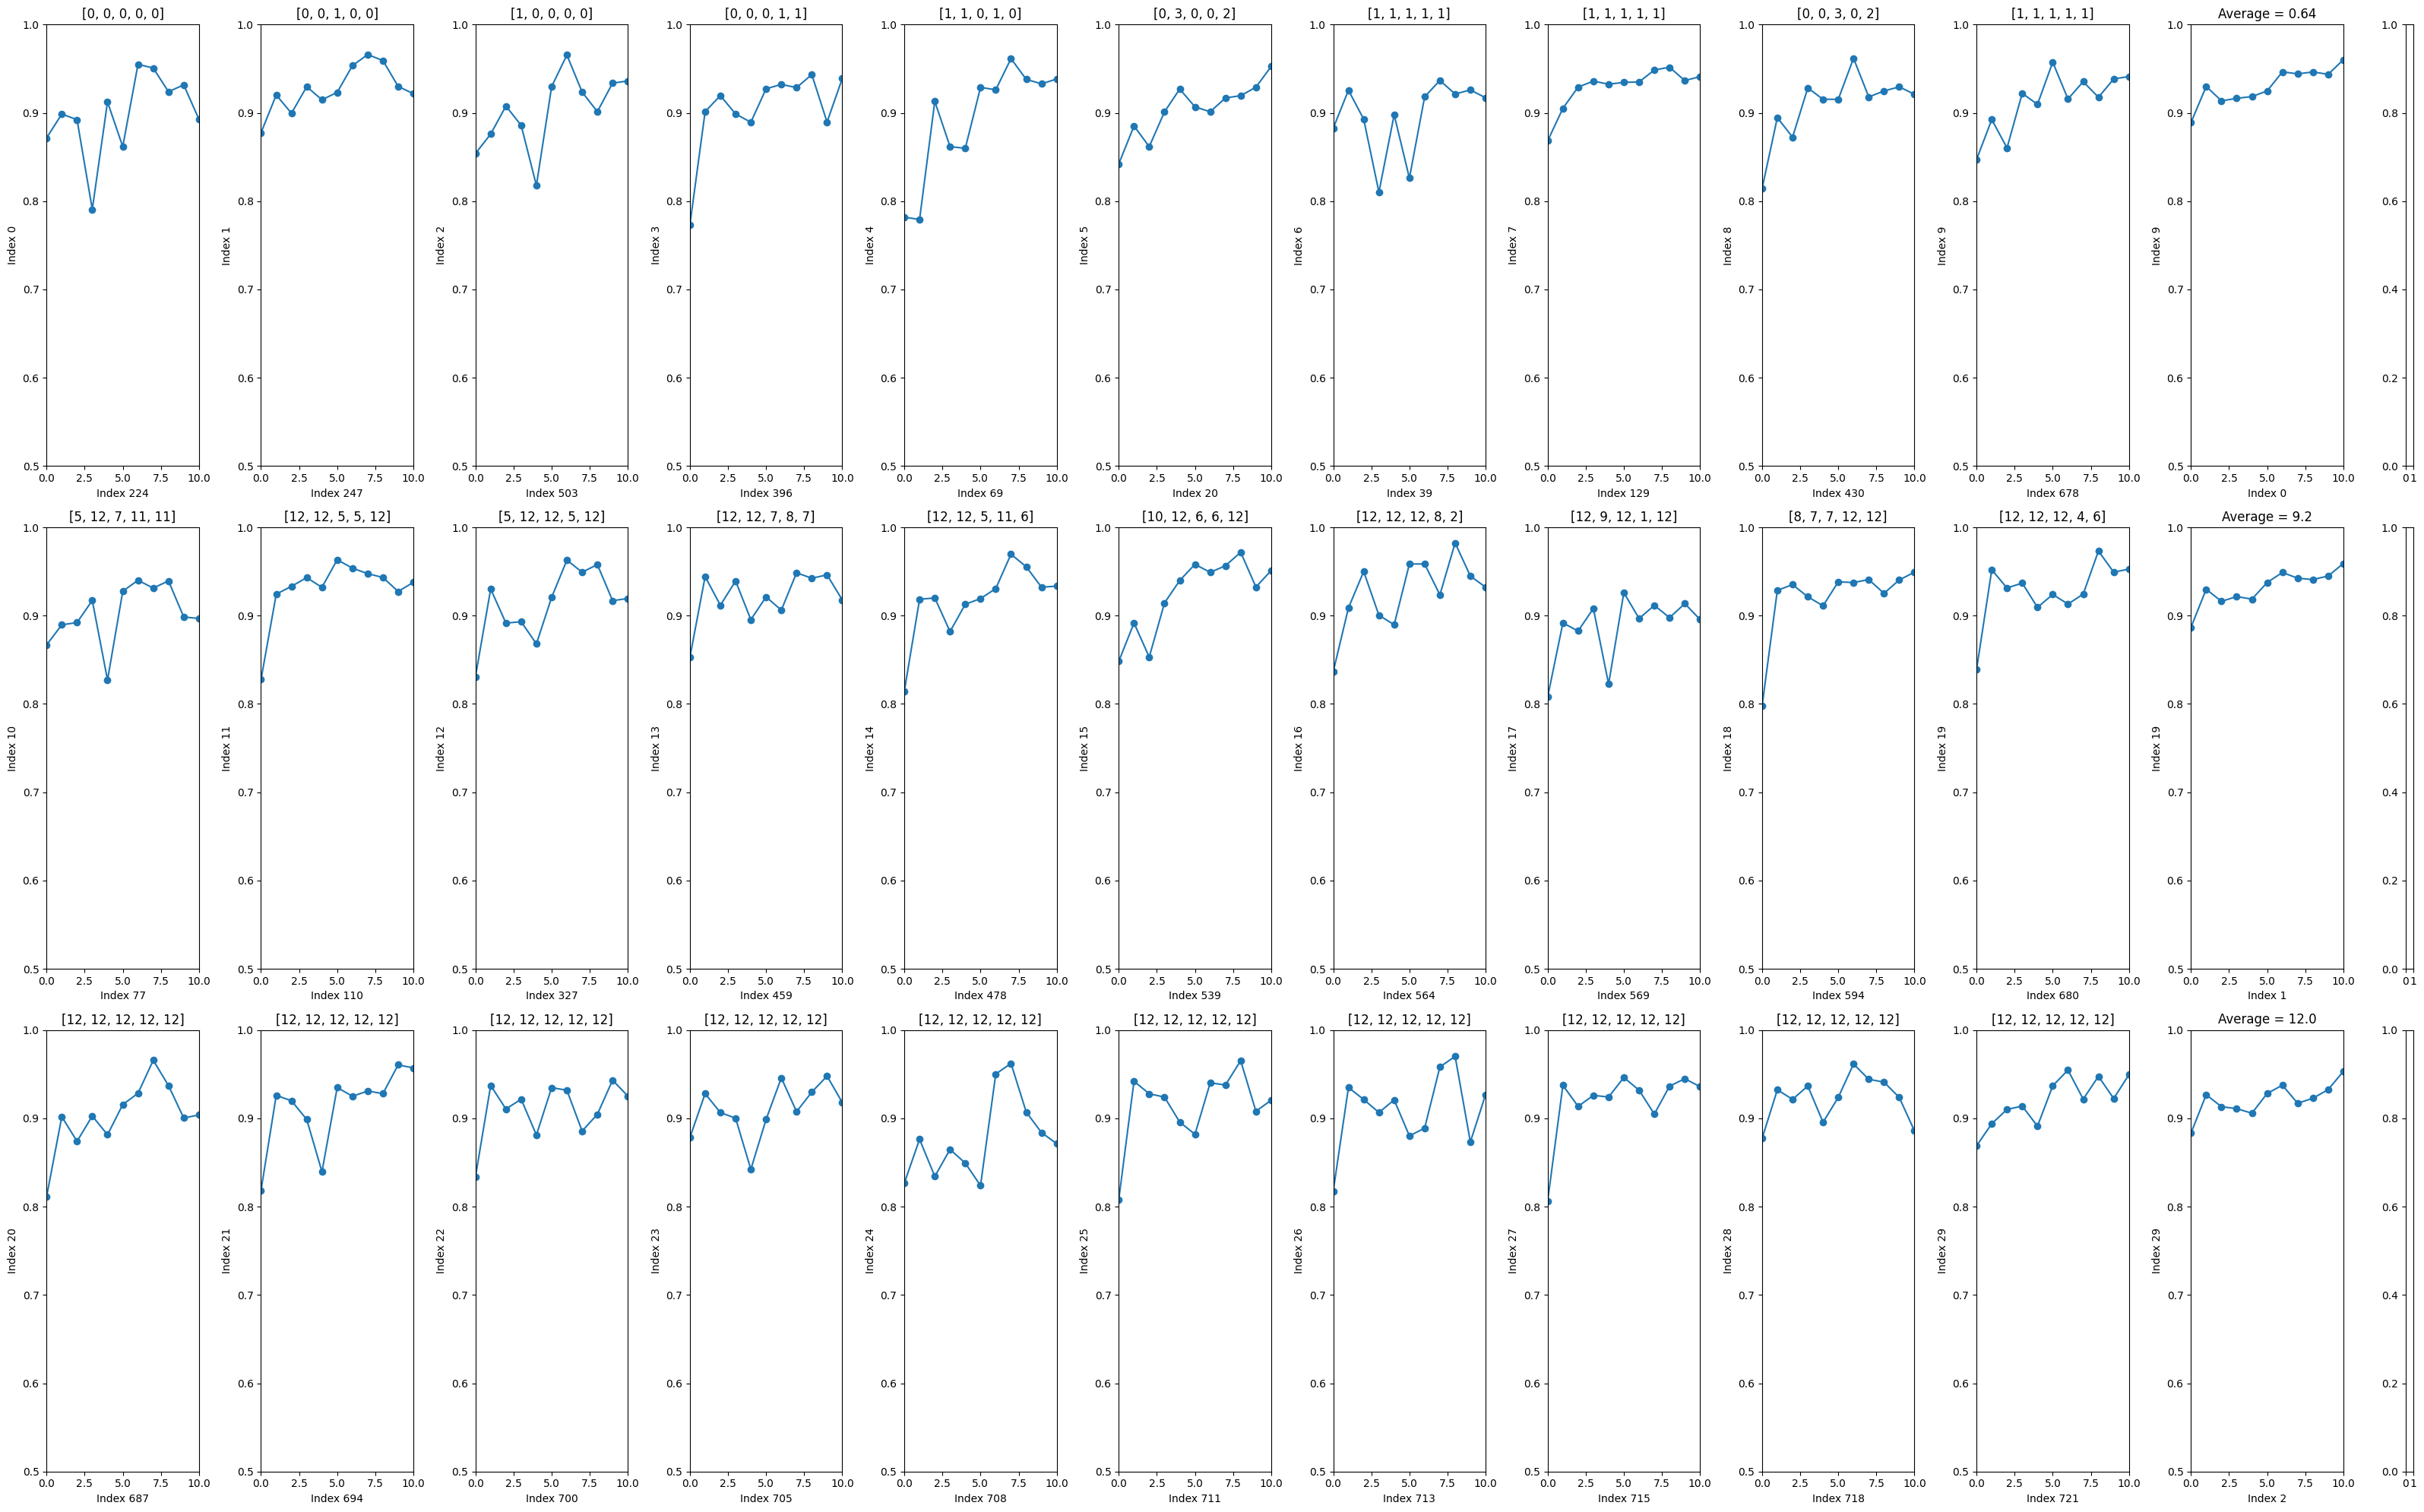

In [16]:
fig, axes = plt.subplots(3, 12, figsize=(32, 20), gridspec_kw={'width_ratios': [1]*11 + [0.05]})
cmap_color = 'Reds'
step = 1
y_min = 0.5
avg_num = 100
# 对每组子图进行处理
for n in range(3):
    for m in range(11):
        k = n * 10 + m
        ax = axes[n, m]  # 使用正确的索引
        
        
        if m!=10:
            ax.set_title(f'{audio_layers[audio_result[k]]}')
            distance=[]
            for i in range(12 - step):
                similarity = F.cosine_similarity(embeddings[f'layer_{i+1}'][k].to(device), embeddings[f'layer_{i+1 + step}'][k].to(device), dim=0)
                distance.append(similarity.to('cpu'))
            
            # 绘制折线图
            ax.plot(range(12 - step), distance, marker='o', linestyle='-')
            ax.set_xlabel(f'Index {audio_result[k]}')
            ax.set_ylabel(f'Index {k}')
            

            # 设置坐标轴范围
            ax.set_xlim(0, 12 - step - 1)
            ax.set_ylim(y_min, 1)

            # 设置坐标轴标签
            ax.set_xlabel(f'Index {audio_result[k]}')
            ax.set_ylabel(f'Index {k}')
        elif m==10:
            average=0
            for k in range(n*10,n*10+10):
                average+=sum(audio_layers[audio_result[k]])
            ax.set_title(f'Average = {average/50 }')
            
            distance=[]
            for i in range(12 - step):
                similarity = F.cosine_similarity(embeddings_average[f'layer_{i+1}'][n].to(device), embeddings_average[f'layer_{i+1 + step}'][n].to(device), dim=0)
                distance.append(similarity.to('cpu'))
            
            # 绘制折线图
            ax.plot(range(12 -step), distance, marker='o', linestyle='-')

            # 设置坐标轴标签
            ax.set_xlabel(f'Index {n}')
            ax.set_ylabel(f'Index {k}')

            # 设置坐标轴范围
            ax.set_xlim(0, 12 - step - 1)
            ax.set_ylim(y_min, 1)

plt.tight_layout()

# 保存图像
plt.savefig('../figs/audio_similarity_matrices_line.png')

In [17]:
avg_num = 50
audio_result=sorted_indices[0:avg_num]+sorted_indices[400:400+avg_num]+sorted_indices[900:900+avg_num]
embeddings={}
embeddings_average={}
with torch.no_grad():
    for i in range(1,13):
        embeddings[f'layer_{i}']=[]
        embeddings_average[f'layer_{i}']=[]
    for a_block in range(1,13):
        checkpoint = torch.load(f'/data/air/pc/Mobile-Search-Engine/embeddings_{a_block}.pth')
        # 获取模型参数和张量
        emb= checkpoint['audio_embeddings']
        for k in audio_result:
            embeddings[f'layer_{a_block}'].append(emb[int(k)])
        for i in range(3):
                sum_vector = torch.stack(embeddings[f'layer_{a_block}'][i:i+avg_num]).sum(dim=0)

                # 计算平均向量
                mean_vector = sum_vector / avg_num

                embeddings_average[f'layer_{a_block}'].append(mean_vector)

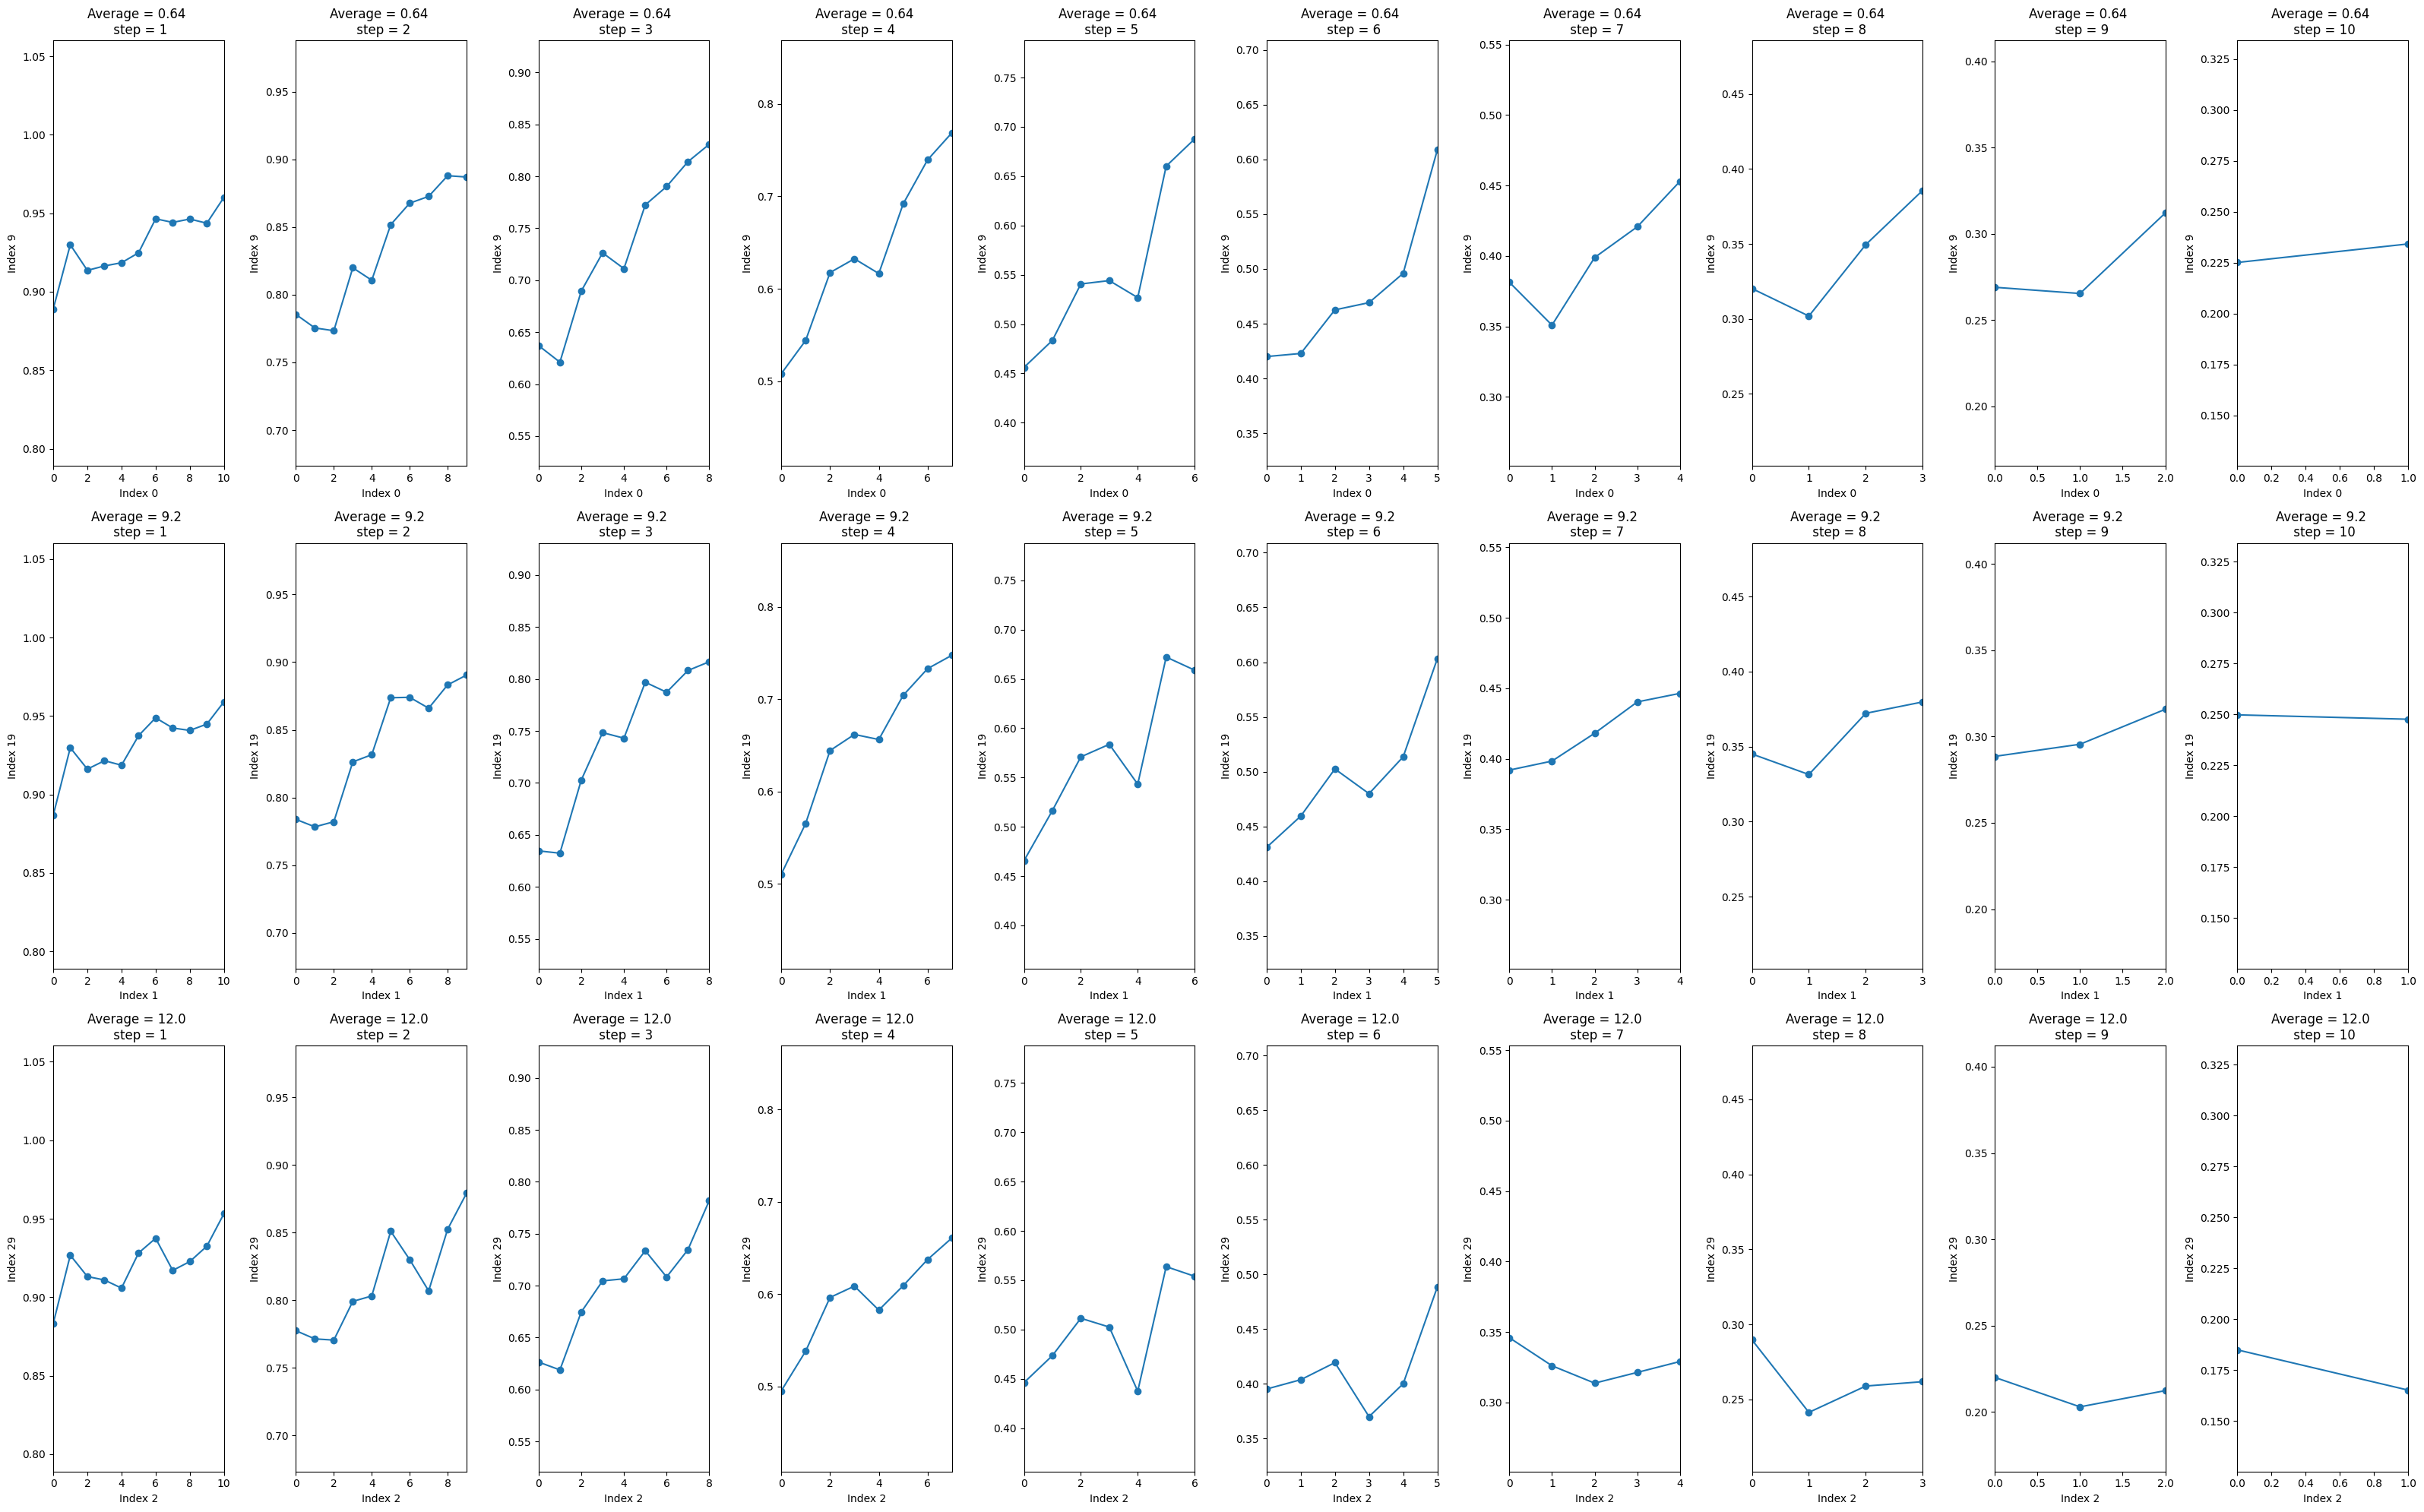

In [14]:
max_step = 10
step_list = range(1, max_step + 1)
fig, axes = plt.subplots(3, max_step, figsize=(32, 20), gridspec_kw={'width_ratios': [1]*max_step})
cmap_color = 'Reds'
y_min = 0
# 看每k步的相似度的变化趋势

for step in step_list:
    set_flag = True # to reset the y-axis range
    for n in range(3):
        ax = axes[n, step-1]  # 使用正确的索引
        
        average=0
        for k in range(n*avg_num,n*avg_num+avg_num):
            average+=sum(audio_layers[audio_result[k]])
        ax.set_title(f'Average = {average/ (avg_num * 5)} \n step = {step}')
        
        distance=[]
        for i in range(12 - step):
            similarity = F.cosine_similarity(embeddings_average[f'layer_{i+1}'][n].to(device), embeddings_average[f'layer_{i+1 + step}'][n].to(device), dim=0)
            distance.append(similarity.to('cpu'))
        
        # 绘制折线图
        ax.plot(range(12 -step), distance, marker='o', linestyle='-')

        # 设置坐标轴标签
        ax.set_xlabel(f'Index {n}')
        ax.set_ylabel(f'Index {k}')

        # 设置坐标轴范围
        ax.set_xlim(0, 12 - step - 1)
        if set_flag:
            y_min = min(distance)-0.1
            y_max = max(distance)+0.1
            set_flag = False
        ax.set_ylim(y_min, y_max)

plt.tight_layout()

# 保存图像
plt.savefig('../figs/audio_similarity_matrices_line_step.png')

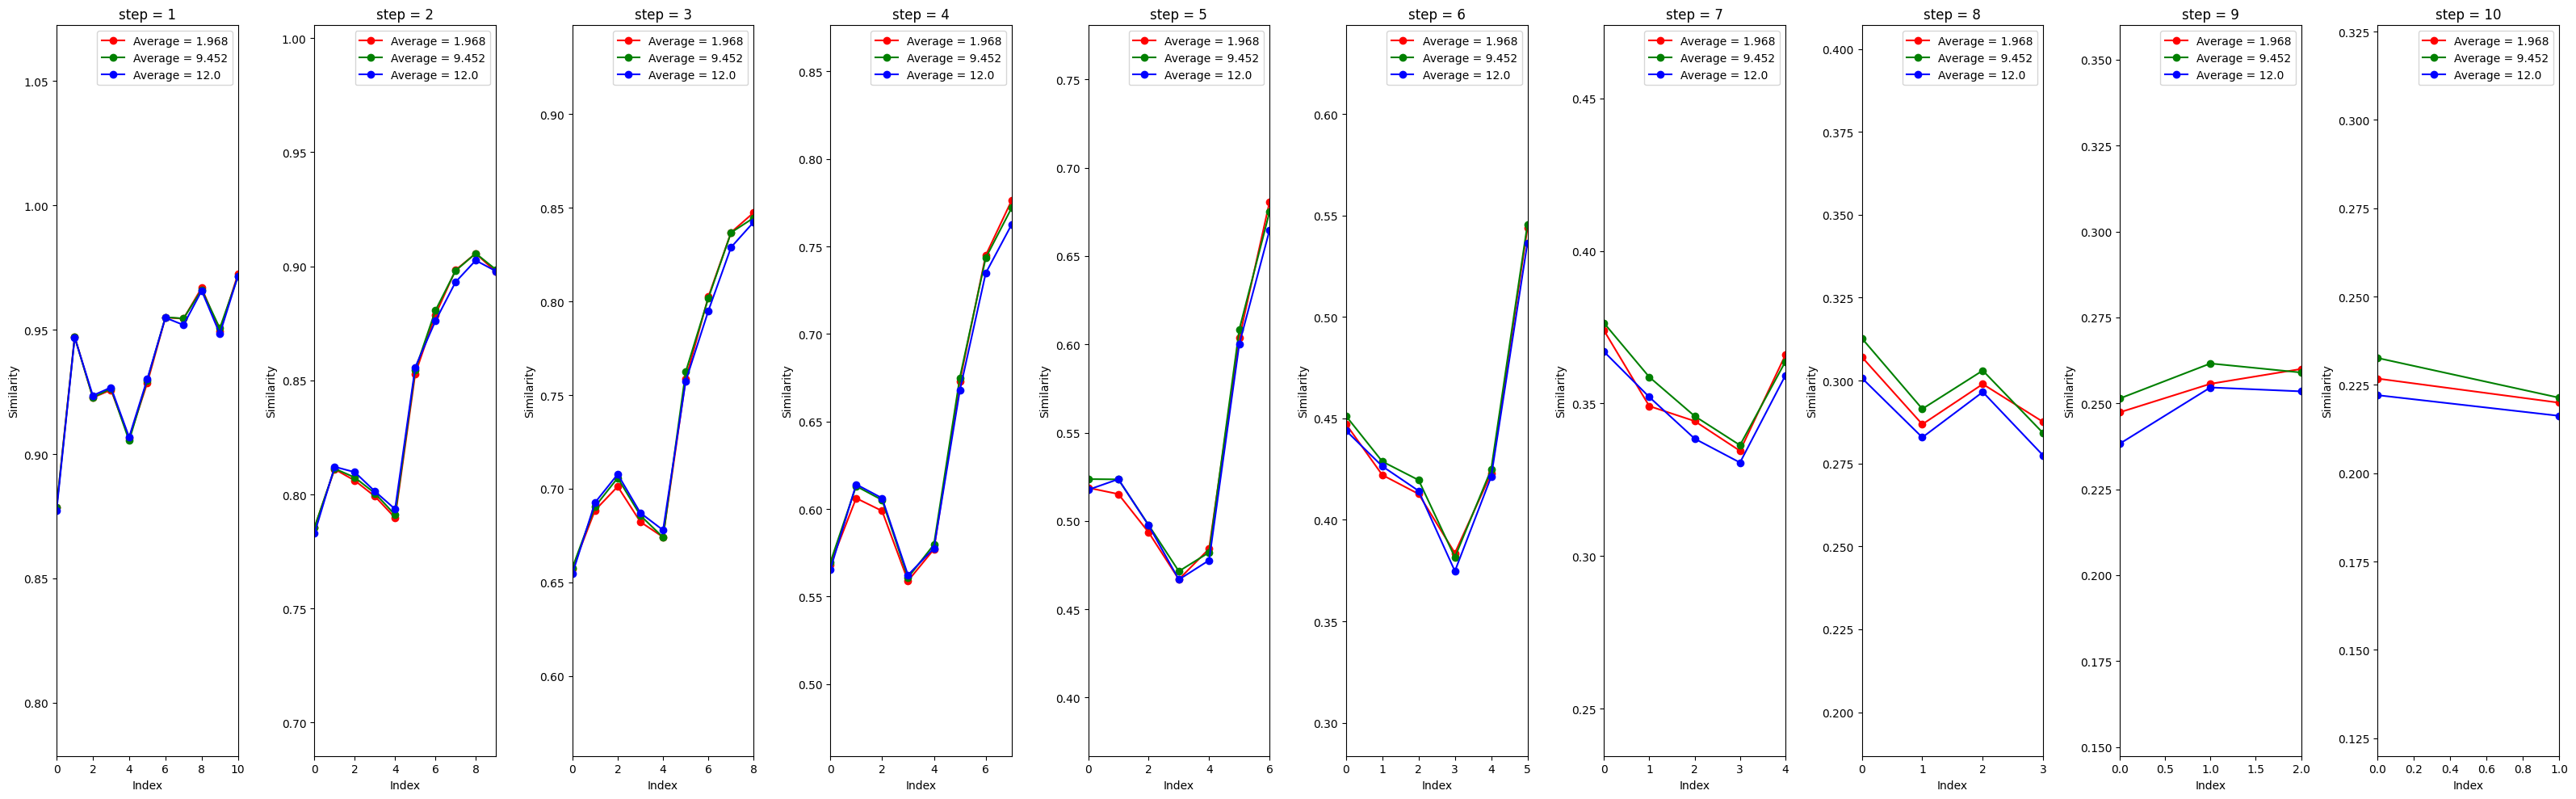

In [18]:
# 把三张图合成一张
max_step = 10
step_list = range(1, max_step + 1)
fig, axes = plt.subplots(1, max_step, figsize=(32, 10), gridspec_kw={'width_ratios': [1]*max_step})  # 改为单行
colors = ['Red', 'Green', 'Blue']  # 为每一行定义颜色
cmap_color = 'Reds'
y_min = 0

for step in step_list:
    set_flag = True  # to reset the y-axis range
    for n in range(3):
        ax = axes[step-1]  # 现在只有一行，所以只使用步骤索引
        
        average = 0
        for k in range(n*avg_num, n*avg_num + avg_num):
            average += sum(audio_layers[audio_result[k]])
        if n == 0:  # 只在第一次迭代设置标题
            ax.set_title(f'step = {step}')
        
        distance = []
        for i in range(12 - step):
            similarity = F.cosine_similarity(embeddings_average[f'layer_{i+1}'][n].to(device), embeddings_average[f'layer_{i+1 + step}'][n].to(device), dim=0)
            distance.append(similarity.to('cpu'))
        
        # 绘制折线图，使用定义的颜色
        ax.plot(range(12 - step), distance, marker='o', linestyle='-', color=colors[n], label = f"Average = {average / (avg_num * 5)}")

        ax.legend(loc='upper right')

        # 只在第一次迭代设置坐标轴标签
        if n == 0:
            ax.set_xlabel(f'Index')
            ax.set_ylabel(f'Similarity')

        # 设置坐标轴范围
        ax.set_xlim(0, 12 - step - 1)
        if set_flag:
            y_min = min(distance) - 0.1
            y_max = max(distance) + 0.1
            set_flag = False
        ax.set_ylim(y_min, y_max)


plt.tight_layout()

# 保存图像
plt.savefig('../figs/audio_similarity_matrices_line_step_merge.png')